In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# check if train, val, and test data already exist
if os.path.exists("pistachios_with_cnn_train.csv"):
    # if so, read them directly
    X_train = pd.read_csv("pistachios_with_cnn_train.csv", index_col=0)
    y_train = pd.read_csv("pistachios_with_cnn_train_labels.csv", index_col=0, squeeze=True)
    X_val = pd.read_csv("pistachios_with_cnn_val.csv", index_col=0)
    y_val = pd.read_csv("pistachios_with_cnn_val_labels.csv", index_col=0, squeeze=True)
    X_test = pd.read_csv("pistachios_with_cnn_test.csv", index_col=0)
    y_test = pd.read_csv("pistachios_with_cnn_test_labels.csv", index_col=0, squeeze=True)
else:
    # otherwise, read in the main data frame and split into train, val, and test
    df = pd.read_csv("pistachios_with_cnn.csv")
    X = df[df.columns[4:]]
    y = df["pistachio_type"]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

    # save train, val, and test for future use
    X_train.to_csv("pistachios_with_cnn_train.csv")
    y_train.to_csv("pistachios_with_cnn_train_labels.csv")
    X_val.to_csv("pistachios_with_cnn_val.csv")
    y_val.to_csv("pistachios_with_cnn_val_labels.csv")
    X_test.to_csv("pistachios_with_cnn_test.csv")
    y_test.to_csv("pistachios_with_cnn_test_labels.csv")

# separate hand coded features from the cnn features for train, val, and test
X_train_cnn = X_train[X_train.columns[-8:]].copy()
X_val_cnn = X_val[X_val.columns[-8:]].copy()
X_test_cnn = X_test[X_test.columns[-8:]].copy()
X_train.drop(X_train.columns[-8:], inplace=True, axis=1)
X_val.drop(X_val.columns[-8:], inplace=True, axis=1)
X_test.drop(X_test.columns[-8:], inplace=True, axis=1)

/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
from sklearn.preprocessing import StandardScaler

# use standard scaler to rescale by running fit and transform on hand coded train features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# apply the same transform to val and test
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

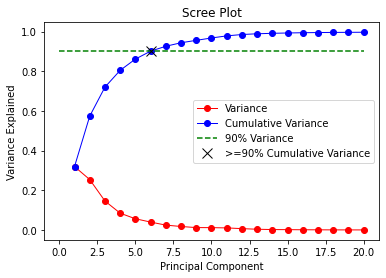

In [3]:
from sklearn.decomposition import PCA

# define PCA model to use on hand coded features
n = 20
pca = PCA(n_components=n)

# fit PCA model
X_train = pca.fit_transform(X_train)
# get cumulative sum of variance and find the dimensions cutoff where we first reach >= 90% variance
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum >= 0.9)[0][0] + 1

# plot scree plot with variance, cumulative variance, and cutoff
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot([0, n], [0.9, 0.9], "g--", label="90% Variance")
plt.plot(cutoff, cum_sum[cutoff - 1], "kx", label=">=90% Cumulative Variance", markersize=10)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

# limit train, val, and test hand coded PCA features up to the first cutoff dimensions
X_train = X_train[:, :cutoff]
X_val = pca.transform(X_val)[:, :cutoff]
X_test = pca.transform(X_test)[:, :cutoff]

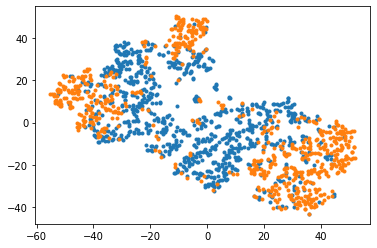

In [4]:
from sklearn.manifold import TSNE

# use tSNE to plot hand coded train features after PCA dimensionality reduction in 2D
tsne = TSNE(n_components=2, random_state=0)
# rescale train PCA data so tSNE can treat dimensions with equal importance
tsne_X = tsne.fit_transform(scaler.fit_transform(X_train))
# plot tSNE of rescaled train PCA data
tsne_plot_x = tsne_X[:, 0]
tsne_plot_y = tsne_X[:, 1]
check_x_0 = tsne_plot_x[y_train == 0]
check_y_0 = tsne_plot_y[y_train == 0]
check_x_1 = tsne_plot_x[y_train == 1]
check_y_1 = tsne_plot_y[y_train == 1]
plt.plot(check_x_0, check_y_0, ".")
plt.plot(check_x_1, check_y_1, ".")

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# init and fit logistic regression model to train PCA data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# print training and validation scores and classification metrics
training_score = logreg.score(X_train, y_train)
validation_score = logreg.score(X_val, y_val)
print('Accuracy of logistic regression classifier on validation set: {:.2f} (training {:.2f})'.format(training_score, validation_score))
y_pred = logreg.predict(X_val)
print(metrics.classification_report(y_val, y_pred))

Accuracy of logistic regression classifier on validation set: 0.84 (training 0.82)
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       238
           1       0.75      0.79      0.77       149

    accuracy                           0.82       387
   macro avg       0.81      0.81      0.81       387
weighted avg       0.82      0.82      0.82       387



/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [6]:
from sklearn import svm
# init and fit rbf svc model to train PCA data
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

# print training and validation scores and classification metrics
training_score = clf.score(X_train, y_train)
validation_score = clf.score(X_val, y_val)
print('Accuracy of rbf svm classifier on validation set: {:.2f} (training {:.2f})'.format(training_score, validation_score))
y_pred = clf.predict(X_val)
print(metrics.classification_report(y_val, y_pred))

Accuracy of rbf svm classifier on validation set: 0.94 (training 0.84)
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       238
           1       0.81      0.75      0.78       149

    accuracy                           0.84       387
   macro avg       0.83      0.82      0.83       387
weighted avg       0.84      0.84      0.84       387



/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


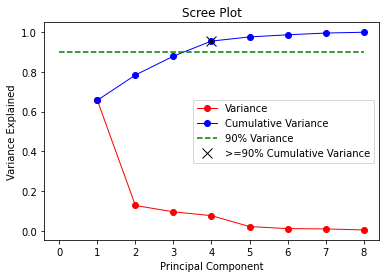

In [7]:
# use standard scaler to rescale by running fit and transform cnn train features
X_train_cnn = scaler.fit_transform(X_train_cnn)
# apply the same transform to val and test
X_val_cnn = scaler.transform(X_val_cnn)
X_test_cnn = scaler.transform(X_test_cnn)

# define PCA model to use on cnn features
n = 8
pca = PCA(n_components=n)

# fit PCA model
X_train_cnn = pca.fit_transform(X_train_cnn)
# get cumulative sum of variance and find the dimensions cutoff where we first reach >= 90% variance
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum >= 0.9)[0][0] + 1

# plot scree plot with variance, cumulative variance, and cutoff
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot([0, n], [0.9, 0.9], "g--", label="90% Variance")
plt.plot(cutoff, cum_sum[cutoff - 1], "kx", label=">=90% Cumulative Variance", markersize=10)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

# limit train, val, and test cnn PCA features up to the first cutoff dimensions
X_train_cnn = X_train_cnn[:, :cutoff]
X_val_cnn = pca.transform(X_val_cnn)[:, :cutoff]
X_test_cnn = pca.transform(X_test_cnn)[:, :cutoff]

In [8]:
# combine hand coded PCA features with cnn PCA features after both had dimensions reduced
X_train_with_cnn = np.hstack([X_train, X_train_cnn])
X_val_with_cnn = np.hstack([X_val, X_val_cnn])
X_test_with_cnn = np.hstack([X_test, X_test_cnn])

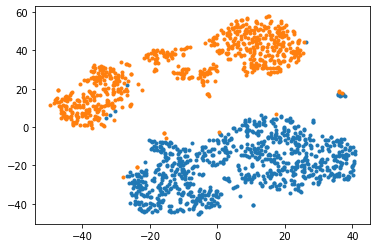

In [9]:
# use tSNE to plot combined features after PCA dimensionality reduction in 2D
tsne = TSNE(n_components=2, random_state=0)
# rescale combined train PCA data so tSNE can treat dimensions with equal importance
tsne_X_with_cnn = tsne.fit_transform(scaler.fit_transform(X_train_with_cnn))
# plot tSNE of rescaled combined train PCA data
tsne_plot_with_cnn_x = tsne_X_with_cnn[:, 0]
tsne_plot_with_cnn_y = tsne_X_with_cnn[:, 1]
check_x_with_cnn_0 = tsne_plot_with_cnn_x[y_train == 0]
check_y_with_cnn_0 = tsne_plot_with_cnn_y[y_train == 0]
check_x_with_cnn_1 = tsne_plot_with_cnn_x[y_train == 1]
check_y_with_cnn_1 = tsne_plot_with_cnn_y[y_train == 1]
plt.plot(check_x_with_cnn_0, check_y_with_cnn_0, ".")
plt.plot(check_x_with_cnn_1, check_y_with_cnn_1, ".")

In [10]:
# init and fit logistic regression model to combined train PCA data
logreg = LogisticRegression()
logreg.fit(X_train_with_cnn, y_train)

# print training and validation scores and classification metrics
training_score = logreg.score(X_train_with_cnn, y_train)
validation_score = logreg.score(X_val_with_cnn, y_val)
print('Accuracy of logistic regression classifier on validation set: {:.2f} (training {:.2f})'.format(training_score, validation_score))
y_pred = logreg.predict(X_val_with_cnn)
print(metrics.classification_report(y_val, y_pred))

Accuracy of logistic regression classifier on validation set: 1.00 (training 1.00)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      0.99      1.00       149

    accuracy                           1.00       387
   macro avg       1.00      1.00      1.00       387
weighted avg       1.00      1.00      1.00       387



/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
# init and fit rbf svc model to combined train PCA data
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_with_cnn, y_train)

# print training and validation scores and classification metrics
training_score = clf.score(X_train_with_cnn, y_train)
validation_score = clf.score(X_val_with_cnn, y_val)
print('Accuracy of rbf svm classifier on validation set: {:.2f} (training {:.2f})'.format(training_score, validation_score))
y_pred = clf.predict(X_val_with_cnn)
print(metrics.classification_report(y_val, y_pred))

Accuracy of rbf svm classifier on validation set: 1.00 (training 0.99)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       238
           1       1.00      0.99      0.99       149

    accuracy                           0.99       387
   macro avg       1.00      0.99      0.99       387
weighted avg       0.99      0.99      0.99       387



/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [1]:
import pandas as pd
df = pd.read_csv("pistachios.csv", index_col=0)
df.head()

/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,filename,filename_camelcase,pistachio_type,major_axis,minor_axis,area,perimeter,ellipse_area,ellipse_perimeter,major_axes,...,k,r,co,sf1,sf2,sf3,sf4,percent_area,distance_from_ellipse,average_hue
0,kirmizi (23).jpg,kirmizi_23.jpg,0,453.495544,220.994598,78732.0,1216.631593,78712.655547,1120.665639,453.495544,...,2.052066,0.787594,0.698079,0.005761,0.002808,0.487314,0.487314,0.240742,0.747299,104.021402
1,kirmizi 21.jpg,kirmizi_21.jpg,0,464.291748,248.325897,89545.0,1268.371705,90553.003463,1169.652914,464.291748,...,1.869687,0.831761,0.731334,0.005127,0.002742,0.534849,0.534849,0.271703,0.862266,108.530097
2,kirmizi 35.jpg,kirmizi_35.jpg,0,481.507446,219.244537,82487.0,1223.376759,82912.816940,1175.303335,481.507446,...,2.196212,0.754278,0.674781,0.005807,0.002644,0.455329,0.455329,0.246336,0.933590,103.808665
3,kirmizi 475.jpg,kirmizi_475.jpg,0,455.230591,236.374313,83621.5,1189.217379,84512.626684,1139.466757,455.230591,...,1.925889,0.817953,0.720584,0.005387,0.002797,0.519241,0.519241,0.252661,1.123648,106.372142
4,kirmizi 313.jpg,kirmizi_313.jpg,0,416.695648,225.598877,73160.5,1095.702659,73832.194933,1052.621353,416.695648,...,1.847064,0.837358,0.735799,0.005644,0.003056,0.541400,0.541400,0.224061,1.001319,105.179346


In [2]:
tmp = pd.read_csv("second_last_layer.csv", index_col=0)
tmp.head()

,0,1,2,3,4,5,6,7
0,0.000000,0.000000,0.009042,0.396989,0.0,0.027226,0.000138,0.0
1,0.000000,0.000000,0.000000,0.386188,0.0,0.021057,0.000124,0.0
2,0.000000,0.000000,0.000000,0.383872,0.0,0.023287,0.000180,0.0
3,0.000000,0.000000,0.000000,0.389859,0.0,0.015770,0.000124,0.0
4,0.031194,0.034356,0.021480,0.320941,0.0,0.039477,0.000101,0.0


In [3]:
df = pd.concat([df, tmp], axis=1)
df.head()
df.to_csv("pistachios_with_cnn.csv")

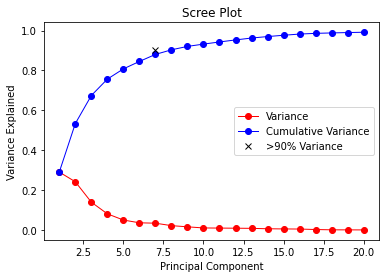

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_X = scaler.fit_transform(df[df.columns[3:]])

#define PCA model to use
pca = PCA(n_components=20)

#fit PCA model to data
pca_fit = pca.fit_transform(scaled_X)
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum > 0.9)[0][0]

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot(cutoff, cum_sum[cutoff], "kx", label=">90% Variance")
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

In [5]:
import statsmodels.api as sm
X = pca_fit[:, :cutoff + 1]
y = df["pistachio_type"]
logit_model=sm.Logit(y,X)
result=logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.004635
         Iterations 14


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
==============================================================
Model:              Logit            Pseudo R-squared: 0.993  
Dependent Variable: pistachio_type   AIC:              35.9115
Date:               2022-07-24 18:14 BIC:              81.2898
No. Observations:   2148             Log-Likelihood:   -9.9557
Df Model:           7                LL-Null:          -1465.6
Df Residuals:       2140             LLR p-value:      0.0000 
Converged:          1.0000           Scale:            1.0000 
No. Iterations:     14.0000                                   
----------------------------------------------------------------
        Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
----------------------------------------------------------------
x1      0.6054     0.2270    2.6665   0.0077    0.1604    1.0504
x2     -2.2938     0.6528   -3.5139   0.0004   -3.5732   -1.0144
x3      2.8972     0.8244    3.5145   0.0004    1.2815    4.5129
x4      2.6156     0.7631    3.4275   0.0006    1.1199    4.1113
x5      0.5332     0.2954    1.8050   0.0711   -0.0458    1.1122
x6      1.0480     0.4302    2.4361   0.0148    0.2048    1.8912
x7      5.6431     1.5054    3.7486   0.0002    2.6926    8.5935
x8      0.7762     0.5191    1.4954   0.1348   -0.2411    1.7936
==============================================================

"""

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(metrics.classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 1.00
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       374
           1       1.00      0.99      1.00       271

    accuracy                           1.00       645
   macro avg       1.00      1.00      1.00       645
weighted avg       1.00      1.00      1.00       645



/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [7]:
logreg.score(X, y)

0.9986033519553073

In [8]:
from sklearn.manifold import TSNE
# dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
tsne_X = tsne.fit_transform(scaled_X) # 2D representation
# y    = range(len(digits.target_names)) # labels for visual
# visualize
# plt.figure(figsize=(10, 10))
tsne_X

array([[-11.492138 ,  -5.8462124],
       [ -2.834706 ,  32.25245  ],
       [ -0.7666459,  24.98514  ],
       ...,
       [ 21.767897 ,  20.163347 ],
       [ 26.433018 ,  56.080322 ],
       [ 29.956652 , -56.034904 ]], dtype=float32)

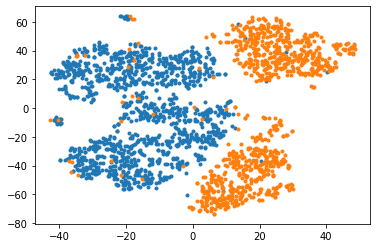

In [9]:
tsne_plot_x = tsne_X[:, 0]
tsne_plot_y = tsne_X[:, 1]
check_x_0 = tsne_plot_x[y == 0]
check_y_0 = tsne_plot_y[y == 0]
check_x_1 = tsne_plot_x[y == 1]
check_y_1 = tsne_plot_y[y == 1]
plt.plot(check_x_0, check_y_0, ".")
plt.plot(check_x_1, check_y_1, ".")

In [10]:
from sklearn import svm
clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9968992248062015

In [11]:
y_pred = clf.predict(X_test)
print('Accuracy of linear svm classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(metrics.classification_report(y_test, y_pred))

Accuracy of linear svm classifier on test set: 1.00
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       374
           1       1.00      0.99      1.00       271

    accuracy                           1.00       645
   macro avg       1.00      1.00      1.00       645
weighted avg       1.00      1.00      1.00       645



In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("pistachios_with_cnn.csv")
X = df[df.columns[3:]]
y = df["pistachio_type"]

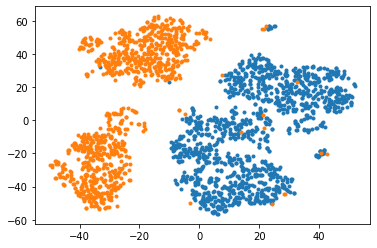

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
tsne_X = tsne.fit_transform(scaled_X) # 2D representation
tsne_plot_x = tsne_X[:, 0]
tsne_plot_y = tsne_X[:, 1]
check_x_0 = tsne_plot_x[y == 0]
check_y_0 = tsne_plot_y[y == 0]
check_x_1 = tsne_plot_x[y == 1]
check_y_1 = tsne_plot_y[y == 1]
plt.plot(check_x_0, check_y_0, ".")
plt.plot(check_x_1, check_y_1, ".")

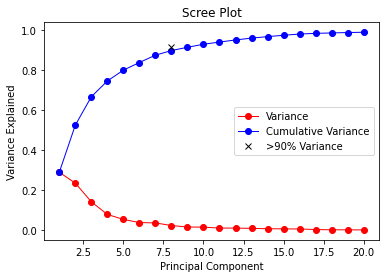

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.3, random_state=0)

#define PCA model to use
pca = PCA(n_components=20)

#fit PCA model to data
pca_fit = pca.fit_transform(X_train)
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum > 0.9)[0][0]

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot(cutoff, cum_sum[cutoff], "kx", label=">90% Variance")
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

X_train = pca_fit[:, :cutoff]

In [37]:
print(X_train.min(), X_train.max(), X_test.min(), X_test.max())
X_train.mean(), X_train.std(), X_test.mean(), X_test.std()

-10.913896580095141 22.23002772395714 -7.734373535970928 12.595671409194738


(-7.800369354651799e-17,
 3.2398131723600945,
 -0.010145869692508263,
 0.9816806541042583)

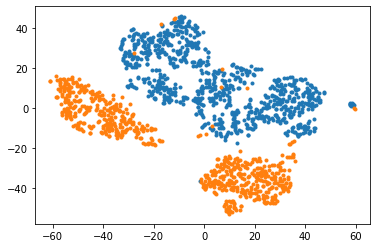

In [12]:
tsne_X = tsne.fit_transform(X_train) # 2D representation
tsne_plot_x = tsne_X[:, 0]
tsne_plot_y = tsne_X[:, 1]
check_x_0 = tsne_plot_x[y_train == 0]
check_y_0 = tsne_plot_y[y_train == 0]
check_x_1 = tsne_plot_x[y_train == 1]
check_y_1 = tsne_plot_y[y_train == 1]
plt.plot(check_x_0, check_y_0, ".")
plt.plot(check_x_1, check_y_1, ".")

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

X_test = pca.transform(X_test)[:, :cutoff]
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(metrics.classification_report(y_test, y_pred))
logreg.score(X_train, y_train)

Accuracy of logistic regression classifier on test set: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       271

    accuracy                           1.00       645
   macro avg       1.00      1.00      1.00       645
weighted avg       1.00      1.00      1.00       645



/Users/aura_dev/.virtualenvs/w281/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9993346640053227

In [14]:
from sklearn import svm
clf = svm.SVC(kernel='linear', C = 1.0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy of linear svm classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(metrics.classification_report(y_test, y_pred))
clf.score(X_test, y_test)

Accuracy of linear svm classifier on test set: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       271

    accuracy                           1.00       645
   macro avg       1.00      1.00      1.00       645
weighted avg       1.00      1.00      1.00       645



0.9984496124031008

In [15]:
X_train.shape, X_test.shape

((1503, 8), (645, 8))